# Unsupervised Learning und Anwendungsgebiete

In diesem Notebook werden die in der Vorlesung 6 Unüberwachtes Lernen aufgezeigten Algorithmen anhand von einfachen Fallbeispielen implementiert.

Zur kurzen Wiederholung: unüberwachtes Lernen heißt Suchen und Erkennen von Mustern in Daten ohne eine definierte Zielgröße (sogenannte "nicht gelabelte Daten"; das kommt später in Supervised Learning).

Man kann sich das so vorstellen, daß man dem Algorithmus viele Daten wie bspw. Bilder gibt, ohne ihm zu sagen welche Bilder einen Elephant, Tiger oder Mensch darstellt. Der Algorithmus versucht dann Muster zu erkennen- dabei können unbekannte, oft aber auch nicht sinnvolle Zusammenhänge als Ergebnis entstehen.

Das Notebook dient also zur Veranschaulichung und gerne auch zur Übernahme für eigene Projekte wie z.B. der Hausarbeit.

## Anomalieerkennung
Die Idee von Anomalieerkennungs-Algorithmen ist das Erkennen von einzelnen Werten, die sich deutlich von den restlichen Punkten unterscheiden. Solche Werte können Messfehler, Fehler, Betrug oder sonstige Ereignisse sein.

### Data preparation

In [1]:
# Importieren der Standard-Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Öffnen des Datasetz
loan_df = pd.read_csv("https://raw.githubusercontent.com/JensKohl/Lecture-Technical_Applications_Data_Management-Slides_and_Notebooks/main/Datasets/Loan_Data.csv")

loan_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


Wir werden das Clustering beispielhaft für 2 Features, AppliantIncome and LoanAmount machen. Wir sehen daß bei LoanAmount NaN, also fehlender Wert, in Zeile 1 steht. Schauen wir uns doch mal genauer an, wie viele Null-Werte wir haben.

In [24]:
loan_df.isna().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,14


Wir ersetzen für unser Beispiel die fehlenden Werte bei LoanIncome durch den Median der ganzen Spalte. Man sollte normalerweise eine solche Ersetzung  im Detail prüfen, aber für eine Veranschaulichung von Clustering ist das ok.

In [4]:
# aktualisiere Spalte LoanAmount: fülle alle leeren Einträge mit dem Median der Spalte
loan_df["LoanAmount"] = loan_df["LoanAmount"].fillna(loan_df['LoanAmount'].median())

In [5]:
loan_df.isna().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,14


Wir visualisieren jetzt die 2 Features ApplicationIncome und LoanIncome mit einem sogenannten Scatter-Plot. Die Visualisierung erfolgt per Matplotlib, Sie können aber auch gerne PyGWalker nehmen.

Da wir mit beiden Werten experimentieren werden, speichern wir beide zusätzlich in einer temporären Matrix

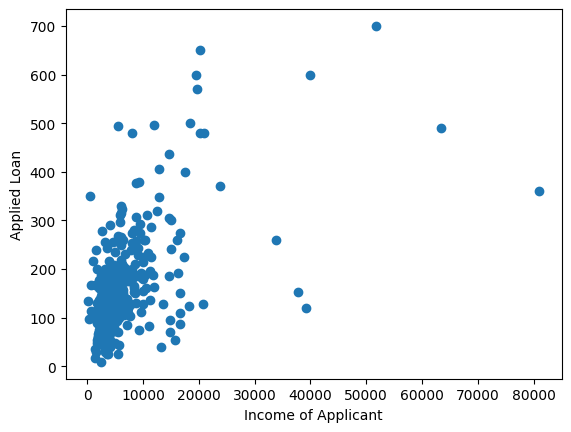

In [6]:
X = loan_df[["ApplicantIncome", "LoanAmount"]]

plt.scatter(X["ApplicantIncome"], X["LoanAmount"]);
plt.xlabel("Income of Applicant");
plt.ylabel("Applied Loan");

Wir sehen auf den ersten Blick, daß es ein paar Ausreisser gibt und daß die meisten Werte zwischen 0 und 20000 Einkommen sind.

In den nächsten Zeilen wenden wir einen Algorithmus an, um Outlier zu entdecken und diese zu visualisieren. Wir nehmen dabei den Algorithmus [Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

In [7]:
# für den Algorithmus dürfen keine leeren Zeilenwerte sein. deshalb aktualisiere Spalte LoanAmount: fülle alle leeren Einträge mit dem Median der Spalte
X["LoanAmount"] = X["LoanAmount"].fillna(X['LoanAmount'].median())
X.isna().sum()

/tmp/ipython-input-3635636565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["LoanAmount"] = X["LoanAmount"].fillna(X['LoanAmount'].median())


,0
ApplicantIncome,0
LoanAmount,0


In [8]:
from sklearn.ensemble import IsolationForest

# Initiieren des Isolation Forest
isolation_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1)

# bestimme outlier in X-Werten
y_hat = isolation_forest.fit_predict(X)

In [9]:
# Aufteilen der Datenmenge in 2 Untermengen mit Outliern und Nicht-outliern, damit man das schöner sehen kann per Graphik
# Herausfiltern aller Outlier.
# genauer gesagt: Non_outlier enthält alle vorhergesagten Werte die ungleich -1 sind
Non_outlier = y_hat != -1
Outlier = y_hat == -1  #  analog obere Zeile

# wir erstellen zwei leere Dataframes in die wir outlier oder nicht outlier speichern
X_non_outlier = pd.DataFrame()
X_outlier = pd.DataFrame()

X_non_outlier["X_AppliantIncome_nonoutlier"], X_non_outlier["X_LoanIncome_nonoutlier"] = X["ApplicantIncome"][Non_outlier], X["LoanAmount"][Non_outlier]
X_outlier["X_AppliantIncome_outlier"], X_outlier["X_LoanIncome_outlier"] = X["ApplicantIncome"][Outlier], X["LoanAmount"][Outlier]

In [10]:
X_non_outlier.isna().sum()

,0
X_AppliantIncome_nonoutlier,0
X_LoanIncome_nonoutlier,0


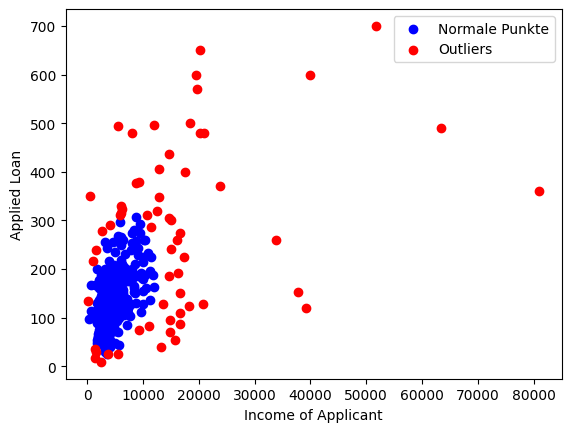

In [11]:
ax = plt.gca()
# Zeichne die Nicht-Outlier als blaue Punkte ("b")
ax.scatter(x=X_non_outlier["X_AppliantIncome_nonoutlier"],
           y=X_non_outlier["X_LoanIncome_nonoutlier"],
           c="b",
           label="Normale Punkte")

# Zeichne die Nicht-Outlier als rote Punkte ("r")
ax.scatter(x=X_outlier["X_AppliantIncome_outlier"],
           y=X_outlier["X_LoanIncome_outlier"],
           color="r",
           label="Outliers")

ax.legend() #zeichne eine Legende
plt.xlabel("Income of Applicant"); # benenne X-Achse
plt.ylabel("Applied Loan"); # benenne y-Achse
ax = plt.subplot() # zeichne Plot nachdem alle Einstellungen fertig



Im weiteren Verlauf arbeiten wir mit den nicht-outlierWerten weiter, alle anderen löschen wir.

## Clustering
Die Idee von Clustering-Algorithmen ist die Aufteilung einer Datenmenge in verschiedenen Gruppen so daß die Mitglieder einer Gruppe sich untereinander mehr ähneln als Mitgliedern anderer Gruppen.

Ein Beispiel hierfür ist eine Einteilung einer Schulklasse in verschiedene Untergruppen, bspw. anhand Größe, Geburtsmonat, ...

Wir setzen den aus der Vorlesung vorgestellten KMeans-Algorithmus ein für Clustering von Personen aus dem aus der vorigen Vorlesung bekannten **Loan**-Datensatz.

KMeans teilt eine gegebene Menge in k verschiedene Gruppen ein. Dabei wird für jede der k Gruppen ein Mittelpunkt berechnet, von dem alle Mitglieder den gleichen Abstand haben. Eine genaue Dokumentation von KMeans ist verfügbar unter [Link](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html).

KMeans ist ein schnell einsetzbarer Algorithmus, der aber 2 Nachteile hat:

- der Algorithmus erklärt nicht, wieso er wie geclustert hat.
- die Anzahl Cluster muß vornherein mitgegeben werden. Oft kennen wir aber die Struktur der Daten nicht und wissen somit auch nicht, wie viele Cluster wir benötigen. Wir sehen weiter unten eine Methode um grob eine recht gute Anzahl Cluster bestimmen zu können.

Schauen wir uns jetzt doch das Ergebnis der Filterung auf non_outlier an.

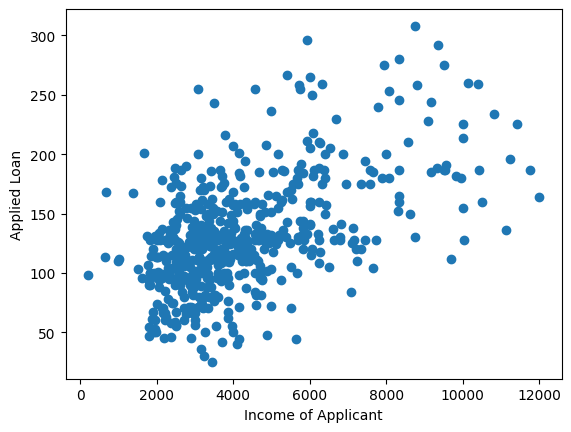

In [12]:
plt.scatter(X_non_outlier["X_AppliantIncome_nonoutlier"], X_non_outlier["X_LoanIncome_nonoutlier"]);
plt.xlabel("Income of Applicant");
plt.ylabel("Applied Loan");

Ziel ist, es alle Punkte dieses Graphen in trennscharfe Untergruppen einzuteilen. Im realen Leben ist es immer eine Herausforderung, die richtige Anzahl der Untergruppen zu finden:

- Zu viele Untergruppen: Abbildung verschiedener Eigenschaften möglich, aber verhindert eine Generalisierung/ Verallgemeinerung.
- zu wenige Untergruppen: erleichtert die Arbeit, die Einteilung wird aber gröber und man macht falsche Einteilungen. Zudem: wenn man möglichstwenig Untergruppen nimmt, dann hätte man sich das Clustering auch sparen können...

Wir veranschaulichen diesen Konflikt durch Anwendung KMeans mit 2, 3 und dann 8 Untergruppen (der Fall k=1 ist ja immer die Ausgangsmenge im oberen Bild). Anschließend schauen wir uns ein Verfahren an, wie man eine recht gute Anzahl von Gruppen bestimmen kann.

In [13]:
from sklearn.cluster import KMeans

# Anzahl Cluster. Wir fangen mit 2 an.
kmeans = KMeans(n_clusters=2)
# Eingabedaten "fitten", d.h. einpassen in 2 Gruppen. Hier geschieht die Arbeit des Algorithmus.
kmeans = kmeans.fit(X_non_outlier)

# Einteilen der Daten in 2 Cluster
clusters = kmeans.predict(X_non_outlier)

# Auswerten der Zentrumspunkte je Cluster
centroids = kmeans.cluster_centers_
print(centroids) # From sci-kit learn

[[7319.484375    175.09375   ]
 [3299.12971698  117.81367925]]


Was hat das jetzt gebracht? Was soll die Ausgabe mit den 2 Zeilen bringen?

Dazu schauen wir uns das graphisch an:

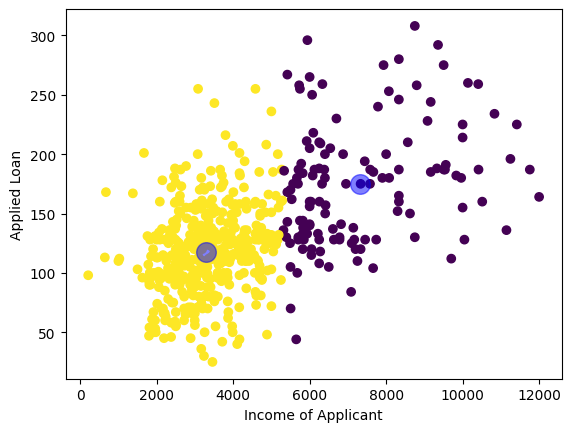

In [14]:
# mach ein scatter plot für die Werte
plt.scatter(X_non_outlier["X_AppliantIncome_nonoutlier"],
            X_non_outlier["X_LoanIncome_nonoutlier"],
            c=clusters, # zeichne die durch kmeans eingeteilten Gruppen in verschiedenen Farben
)
plt.xlabel("Income of Applicant");
plt.ylabel("Applied Loan");

# wir plotten jetzt die Centroids aus dem vorigen Block
plt.scatter(centroids[:, 0],
            centroids[:, 1],
            c='blue',
            s=200,
            alpha=0.5)

Wir sehen daß die Menge in 2 Klassen eingeteilt worden ist mit den blauen Punkten als Mittelpunkt oder Nabe der jeweiligen Gruppe.

Mit Hilfe der Nabe kann auch veranschaulicht werden, was KMeans iterativ macht.

KMeans definiert zufällig eine Anzahl von k Mittelpunkte.
Wiederhole bis es keine Aktualisierungen mehr gibt:
Teile die gesamten Punkte auf in die einzelnen k Gruppen. Dabei kommt ein Punkt in genau die Gruppe, zu deren Mittelpunkt er den geringsten Abstand hat.
Nachdem alle Punkte in eine der k Gruppen eingeteilt wurden, ist der aktuelle Mittelpunkt nicht zwingend mehr der Mittelpunkt der Gruppe. Deshalb wird ein neuer Mittelpunkt je Gruppe berechnet.

Schauen wir uns das ganze für 6 Klassen an:

In [15]:
kmeans = KMeans(n_clusters=6)
kmeans = kmeans.fit(X_non_outlier)
clusters = kmeans.predict(X_non_outlier)

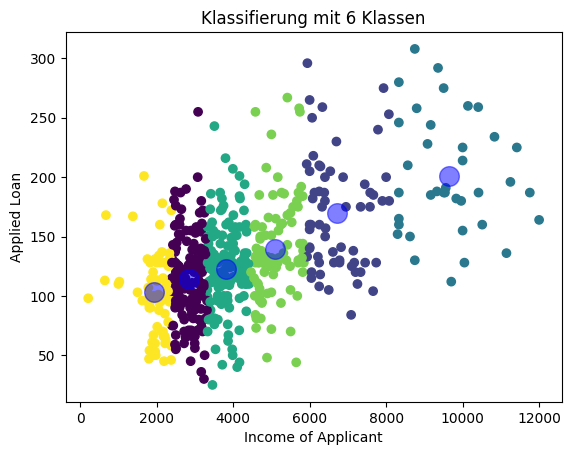

In [16]:
centroids = kmeans.cluster_centers_

# mach ein scatter plot für die Werte
plt.scatter(X_non_outlier["X_AppliantIncome_nonoutlier"],
            X_non_outlier["X_LoanIncome_nonoutlier"],
            c=clusters, # zeichne die durch kmeans eingeteilten Gruppen in verschiedenen Farben
)
plt.title("Klassifierung mit 6 Klassen")
plt.xlabel("Income of Applicant");
plt.ylabel("Applied Loan");

# wir plotten jetzt die Centroids aus dem vorigen Block
plt.scatter(centroids[:, 0],
            centroids[:, 1],
            c='blue',
            s=200,
            alpha=0.5)

Mit 6 Klassen schaut das ganze schon deutlich unübersichtlicher aus; und auch die Gruppen sind nicht mehr trennscharf.

6 Gruppen sind also wohl zuviel - aber wie viele sind dann gut genug? Wie viele Gruppen sollte man denn nehmen, um einen möglichst guten Ausgleich zwischen Generalisierung und Individualisierung zu finden?

Hierfür eignet sich die sogenannte Ellbogen-Methode.

### Ellbogen-Methode

Die Ellbogen-Methode wird [Robert L. Thorndike](https://en.wikipedia.org/wiki/Robert_L._Thorndike) zugeschrieben, der diese 1953 entwickelte.

Der [Wikipedia-Artikel](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.) detailliert die Methode wie folgt:

"Using the "elbow" or "knee of a curve" as a cutoff point is a common heuristic in mathematical optimization to choose a point where diminishing returns are no longer worth the additional cost. In clustering, this means one should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data.

The intuition is that increasing the number of clusters will naturally improve the fit (explain more of the variation), since there are more parameters (more clusters) to use, but that at some point this is over-fitting, and the elbow reflects this.

The idea is that the first clusters will add much information (explain a lot of variation), since the data actually consist of that many groups (so these clusters are necessary), but once the number of clusters exceeds the actual number of groups in the data, the added information will drop sharply, because it is just subdividing the actual groups. Assuming this happens, there will be a sharp elbow in the graph of explained variation versus clusters: increasing rapidly up to k (under-fitting region), and then increasing slowly after k (over-fitting region)."

Wir verwenden 3 Schritte:

1. KMeans mit einer hohen Anzahl von Clustern trainieren. Dabei für jeden Durchlauf den quadrierten Fehler abspeichern im Array sse. Dieser Fehler ist größer, je weniger Klassen es gibt. Man kann sich das also als Generalisierungsfehler vorstellen.
2. Plotten der Graphik für die einzelnen Fehler im Array SSE
3. Plot anschauen und den Ellbogen finden. Das ist der Punkt, an dem der Plot schräg abfällt.

Wir nehmen wieder die gleiche Verteilung von vorher

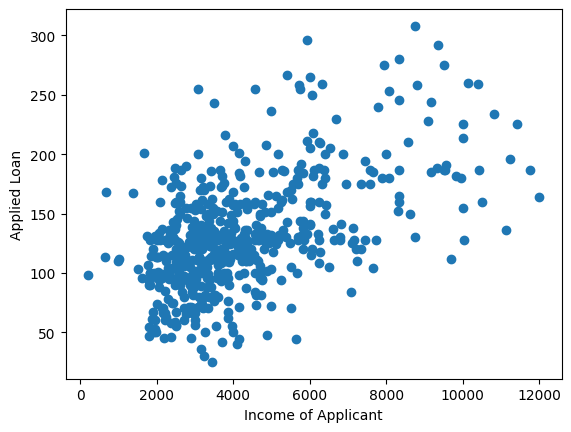

In [17]:
plt.scatter(X_non_outlier["X_AppliantIncome_nonoutlier"],
            X_non_outlier["X_LoanIncome_nonoutlier"])
plt.xlabel("Income of Applicant");
plt.ylabel("Applied Loan");

In [18]:
# Schritt 1: Trainieren
# in Liste sse speichern wir einzelnen Werte je K-Means Versuch
sse = []

# in dieser Schleife rufen wir kMeans für 1 bis 11 Cluster auf
for k in range(1, 11):
  kmeans_loop = KMeans(n_clusters=k);
  kmeans_loop.fit(X_non_outlier);
  #schreibe den Fehler in die Liste
  sse.append(kmeans_loop.inertia_);

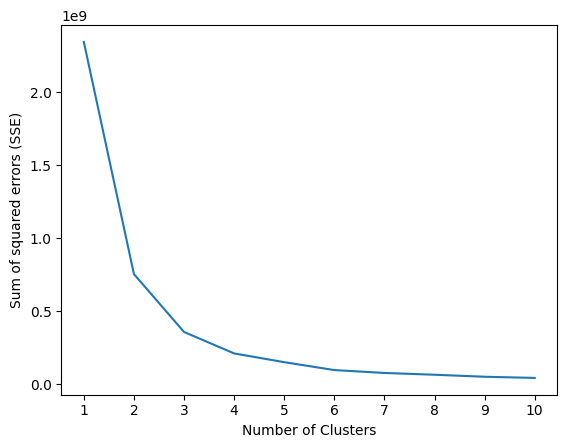

In [19]:
# Schritt 2: Plotten der einzelnen Fehler je KMeans 1-11
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared errors (SSE)")
plt.show()

Der Ellbogen liegt augenscheinlich bei der Zahl 4, 4 scheint also die ideale Anzahl an Gruppen zu sein.

In [20]:
# deshalb nehmen wir die Zahl 4 als Parameter
kmeans_ellbow = KMeans(n_clusters=4)
kmeans_ellbow.fit(X_non_outlier)
cluster = kmeans_ellbow.predict(X_non_outlier)

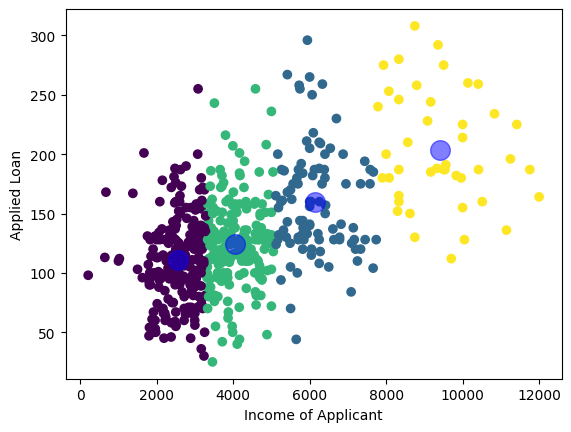

In [21]:
centroids = kmeans_ellbow.cluster_centers_

# mach ein scatter plot für die Werte
plt.scatter(X_non_outlier["X_AppliantIncome_nonoutlier"],
            X_non_outlier["X_LoanIncome_nonoutlier"],
            c=cluster, # zeichne kmeans-Cluster in verschiedene Farben
)

plt.xlabel("Income of Applicant");
plt.ylabel("Applied Loan");

# wir plotten die Mittelpunkte/Centroids aus dem vorigen Block
plt.scatter(centroids[:, 0],
            centroids[:, 1],
            c='blue',
            s=200,
            alpha=0.5)

Eine Einteilung in 3 Gruppen schaut ganz gut aus. Wir können anhand der Graphik schon einige Aussagen machen, wer in welche Gruppe fällt.

Aber wir können das auch mit Python-Anweisungen erhalten:

In [22]:
frame = pd.DataFrame(X_non_outlier)
frame['cluster'] = cluster
frame['cluster'].value_counts()

,count
cluster,
0,219
2,195
1,95
3,43


In [23]:
for i in range(4):
  minIncomeValue = frame.loc[frame['cluster'] == i,"X_AppliantIncome_nonoutlier"].min()
  maxIncomeValue = frame.loc[frame['cluster'] == i,"X_AppliantIncome_nonoutlier"].max()
  minLoanValue = frame.loc[frame['cluster'] == i,"X_LoanIncome_nonoutlier"].min()
  maxLoanValue = frame.loc[frame['cluster'] == i,"X_LoanIncome_nonoutlier"].max()
  print("Cluster {} hat".format(i))
  print("Einkommen von mindestens {} bis maximal {} ".format(minIncomeValue, maxIncomeValue))
  print("Loan von mindestens {} bis maximal {}\n".format(minLoanValue, maxLoanValue))

Cluster 0 hat
Einkommen von mindestens 210 bis maximal 3283 
Loan von mindestens 30.0 bis maximal 255.0

Cluster 1 hat
Einkommen von mindestens 5116 bis maximal 7740 
Loan von mindestens 44.0 bis maximal 296.0

Cluster 2 hat
Einkommen von mindestens 3315 bis maximal 5050 
Loan von mindestens 25.0 bis maximal 255.0

Cluster 3 hat
Einkommen von mindestens 7787 bis maximal 12000 
Loan von mindestens 112.0 bis maximal 308.0

